In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dicoding ML Terapan/Kedua/spotify_songs.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

In [2]:
track = pd.read_csv('dataset/spotify_songs.csv')
track.drop('Unnamed: 0', axis=1, inplace=True)
track.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

In [4]:
track_null = track.isnull().sum()
track_null[track_null > 0]

artists       1
album_name    1
track_name    1
dtype: int64

In [5]:
track.dropna(inplace=True)
track.shape

(113999, 20)

In [7]:
dup_id = track.duplicated(subset=['track_id'], keep=False)
idx_dup_id = dup_id[dup_id == True].index
df_dup = track.loc[idx_dup_id]
df_dup[df_dup['track_id'] == '5SuOikwiRyPMVoIQDJUgSV']

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
62102,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,j-pop
99152,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,singer-songwriter
102151,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,songwriter


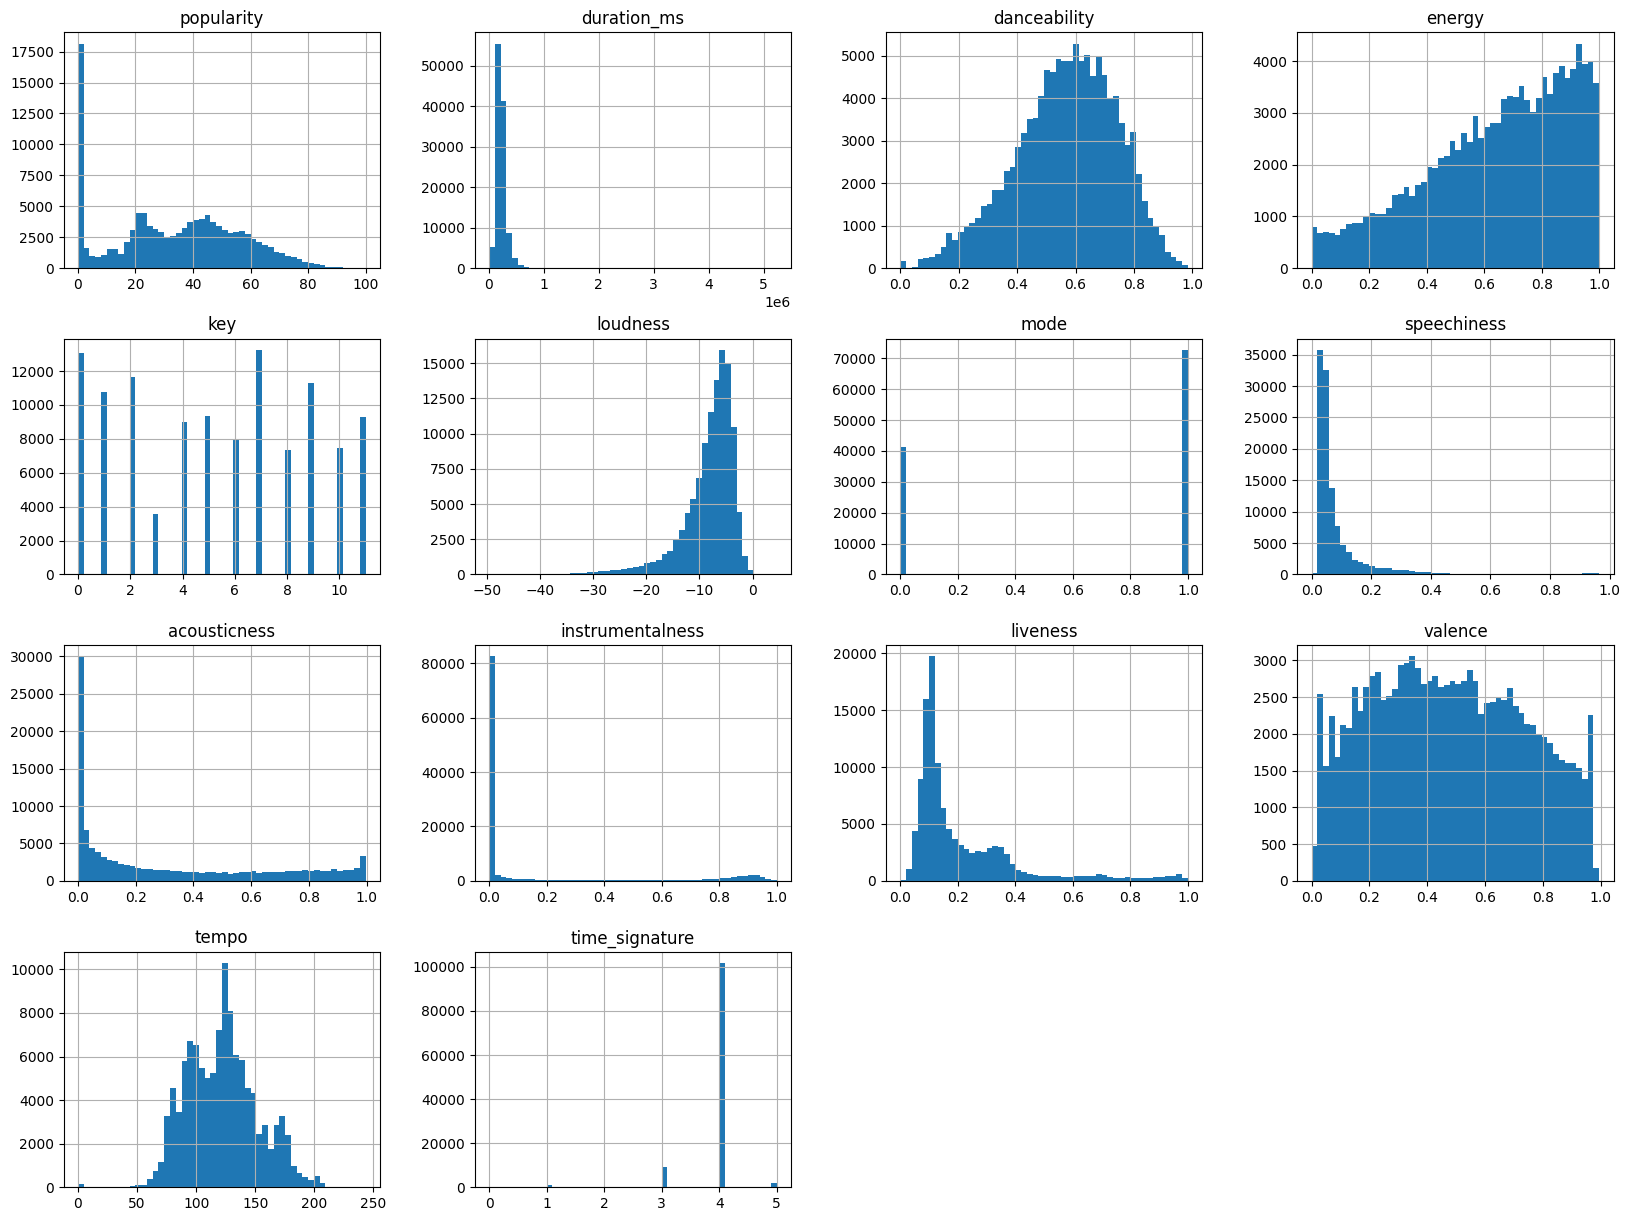

In [8]:
track.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
def get_speech_content(row):
    speech = row['speechiness']
    return 'speech' if speech > 0.66 else 'music'

def get_instrumental_content(row):
    mode = row['instrumentalness']
    return 'instrumental' if mode > 0.85 else 'vocal'

def get_explicit_content(row):
    return 'explicit' if row['explicit'] else 'clean'

def get_mode_content(row):
    mode = row['mode']
    return 'major' if mode == 1 else 'minor'

def get_loudness_content(row):
    loudness = row['loudness']

    if loudness > -7:
        return 'stentorian'
    elif loudness > -11:
        return 'loud'
    elif loudness > -14:
        return 'normal'
    else:
        return 'quiet'

def get_tempo_content(row):
    tempo = row['tempo']

    if tempo < 40:
        return 'grave'
    elif tempo < 45:
        return 'lento'
    elif tempo < 55:
        return 'largo'
    elif tempo < 65:
        return 'adagio'
    elif tempo < 69:
        return 'adagietto'
    elif tempo < 77:
        return 'andante'
    elif tempo < 98:
        return 'moderato'
    elif tempo < 109:
        return 'allegretto'
    elif tempo < 132:
        return 'allegro'
    elif tempo < 140:
        return 'vivace'
    elif tempo < 177:
        return 'presto'
    else:
        return 'prestissimo'

In [10]:
track_uniq = track.drop_duplicates(subset=['artists', 'track_name', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'])
track_uniq = track_uniq[track_uniq['popularity'] >= 60]
track_uniq.shape

(9488, 20)

In [11]:
track_merged = track.groupby('track_id')['track_genre'].agg(list).reset_index()
track_uniq = track_uniq.drop('track_genre', axis=1)
track_uniq = track_uniq.merge(track_merged, on='track_id')
track_uniq['track_genre'] = track_uniq['track_genre'].apply(lambda x:' '.join(x))
track_uniq['track_genre'] = [re.sub(r'-', '', t) for t in track_uniq['track_genre']]

In [12]:
track_uniq['content'] = track_uniq.apply(get_speech_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq.apply(get_instrumental_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq.apply(get_tempo_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq.apply(get_mode_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq.apply(get_loudness_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq.apply(get_explicit_content, axis=1)
track_uniq['content'] = track_uniq['content'] + ' ' + track_uniq['track_genre']

In [13]:
track_uniq.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,content
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic jpop singersongwriter songwriter,music vocal moderato minor stentorian clean ac...
1,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,music vocal prestissimo major quiet clean acou...
2,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,music vocal allegro major loud clean acoustic
3,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,...,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic piano,music vocal presto major loud clean acoustic p...
4,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,11,...,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic rock,music vocal presto major loud clean acoustic rock


In [14]:
tf = TfidfVectorizer()
tf.fit(track_uniq['content'])
tf.get_feature_names_out()

array(['acoustic', 'adagietto', 'adagio', 'afrobeat', 'allegretto',
       'allegro', 'alternative', 'altrock', 'ambient', 'andante', 'anime',
       'bluegrass', 'blues', 'brazil', 'breakbeat', 'british', 'cantopop',
       'chicagohouse', 'children', 'chill', 'classical', 'clean', 'club',
       'comedy', 'country', 'dance', 'dancehall', 'deathmetal',
       'deephouse', 'disco', 'disney', 'drumandbass', 'dub', 'dubstep',
       'edm', 'electro', 'electronic', 'emo', 'explicit', 'folk', 'forro',
       'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grave',
       'groove', 'grunge', 'guitar', 'happy', 'hardcore', 'hardrock',
       'hardstyle', 'heavymetal', 'hiphop', 'house', 'idm', 'indian',
       'indie', 'indiepop', 'industrial', 'instrumental', 'jazz',
       'jdance', 'jidol', 'jpop', 'jrock', 'kids', 'kpop', 'largo',
       'latin', 'latino', 'loud', 'major', 'malay', 'mandopop', 'metal',
       'metalcore', 'minimaltechno', 'minor', 'moderato', 'mpb', 'music',
    

In [15]:
tfidf_matrix = tf.fit_transform(track_uniq['content'])
tfidf_matrix = tfidf_matrix.astype(np.float32)
tfidf_matrix.shape

(9488, 129)

In [16]:
tfidf_matrix.todense()

matrix([[0.5186882 , 0.        , 0.        , ..., 0.        , 0.09963802,
         0.        ],
        [0.6653519 , 0.        , 0.        , ..., 0.        , 0.12781157,
         0.        ],
        [0.81078684, 0.        , 0.        , ..., 0.        , 0.15574904,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.13547343,
         0.8401045 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.13845068,
         0.85856724],
        [0.        , 0.        , 0.        , ..., 0.        , 0.12393811,
         0.76857114]], dtype=float32)

In [17]:
df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=track_uniq['track_name']
)
df_tfidf.sample(10, axis=1).sample(10, axis=0)

,guitar,music,vocal,stentorian,edm,malay,spanish,vivace,sertanejo,indiepop
track_name,,,,,,,,,,
"Marakkuma Nenjam - From ""Vendhu Thanindhathu Kaadu""",0.0,0.138327,0.144224,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Scenes from an Italian Restaurant,0.0,0.163953,0.170942,0.257646,0.0,0.0,0.0,0.000000,0.0,0.0
"Head Over Heels - Dave Bascombe 7"" N.Mix",0.0,0.153291,0.159825,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
MONEY,0.0,0.143444,0.149559,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Aasman Ko Chukar,0.0,0.131446,0.137049,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Bad Influence,0.0,0.132325,0.137966,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
Buddy Holly,0.0,0.139918,0.145883,0.219876,0.0,0.0,0.0,0.000000,0.0,0.0
Headstrong,0.0,0.118664,0.123723,0.186476,0.0,0.0,0.0,0.000000,0.0,0.0
"Mere Sohneya (From ""Kabir Singh"")",0.0,0.169368,0.176588,0.266155,0.0,0.0,0.0,0.612256,0.0,0.0


In [18]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=track_uniq['track_id'], columns=track_uniq['track_id'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9488, 9488)


track_id,70LcF31zb1H0PyJoS1Sx1r,6BvRzfqi3sMAoQYnRpMVL0,5MhsZlmKJG6X5kTHkdwC4B,3cahGAUUQ0n55EjLBs2Wjo,0oA9wBGDY4uyILLg4GymWP
track_id,,,,,
0rWMOzZ7fFYZWI1qlCY4Ig,0.188223,0.094622,0.176093,0.363302,0.057177
3LcMLFApeU9uCT8VCWEVjr,0.171466,0.055038,0.308850,0.096589,0.026620
0ZEeEZnZ496lE6kN7bmSrp,0.149640,0.027968,0.278153,0.501108,0.078526
0cUp7d3a6DHzAuSKBn1NZJ,0.170077,0.085499,0.159116,0.328278,0.051665
5bryfrnYaxlofC6MAG6vde,0.151929,0.254284,0.090371,0.293250,0.046152
70L6nHORQsblY813yNqUR3,0.076761,0.098427,0.311132,0.172735,0.059477
4ID45W7QoisqbyFPst3wih,0.117929,0.070092,0.174058,0.232062,0.104437
1yg7fwwYmx9DQ2TdXUmfpJ,0.210484,0.051138,0.048432,0.397539,0.182683
6Fnvi5QnVkTskSzeRvvQds,0.033995,0.054460,0.112606,0.095574,0.261175


In [19]:
def recommendations(track_id, similarity_data=cosine_sim_df, items=track_uniq, k=10):
    sim = similarity_data.loc[:, track_id].to_numpy()
    idx_range = range(-1, -k, -1)
    index = sim.argpartition(idx_range)
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(track_id, errors='ignore')

    df_closest = pd.DataFrame(closest).merge(items, on='track_id').head(k)
    df_closest = df_closest[['track_id', 'artists', 'track_name', 'content']]
    return df_closest.sample(frac=1).reset_index(drop=True)

In [20]:
track_uniq.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,content
9001,5ZEQjTroORCu6uWvZrdeNc,Cecilia Krull,My Life Is Going On (Música Original De La Ser...,My Life Is Going On (Música Original De La Ser...,62,214200,False,0.427,0.647,6,...,0,0.0353,0.102000,0.000002,0.1330,0.298,99.753,4,spanish,music vocal allegretto minor loud clean spanish
4304,1Yuim9eHBfG8YUJII28XDF,Nickelback,The Long Road,Figured You Out,61,228480,False,0.544,0.867,10,...,1,0.0517,0.000026,0.016500,0.2660,0.726,93.925,4,grunge,music vocal moderato major stentorian clean gr...
9283,798cuJeotvXP8UVa8GJPnD,ABBA,Arrival,"Knowing Me, Knowing You",64,241920,False,0.546,0.733,2,...,1,0.0299,0.039900,0.000001,0.2350,0.910,107.285,4,swedish,music vocal allegretto major loud clean swedish
1894,76cy1WJvNGJTj78UqeA5zr,Dua Lipa,Dua Lipa (Deluxe),IDGAF,80,217946,True,0.836,0.544,7,...,1,0.0943,0.040300,0.000000,0.0824,0.510,97.028,4,dance,music vocal moderato major stentorian explicit...
7988,1FkoVC85Ds3mFoK0fVqEqP,The Offspring,Smash,Self Esteem,77,257826,False,0.488,0.862,0,...,1,0.0476,0.020400,0.000000,0.3590,0.706,104.560,4,punkrock punk ska,music vocal allegretto major loud clean punkro...


In [22]:
recommendations('76cy1WJvNGJTj78UqeA5zr')

,track_id,artists,track_name,content
0,60ynsPSSKe6O3sfwRnIBRf,Doja Cat,Streets,music vocal moderato major loud explicit dance
1,0QBzMgT7NIeoCYy3sJCof1,Camila Cabello;Ed Sheeran,Bam Bam (feat. Ed Sheeran),music vocal moderato major stentorian clean dance
2,6XHVuErjQ4XNm6nDPVCxVX,Chris Brown;Drake,No Guidance (feat. Drake),music vocal moderato minor stentorian explicit...
3,7795WJLVKJoAyVoOtCWqXN,Sam Smith,I'm Not The Only One,music vocal moderato major stentorian clean da...
4,3E9es0SK2EusrHA7IaO7Zu,Charlie Puth,Charlie Be Quiet!,music vocal moderato major stentorian clean dance
5,3UrNOHCzVxX2KZbNcKQAyu,Nicki Minaj;Lil Wayne,High School,music vocal moderato minor stentorian explicit...
6,21TcDbGosp7w9YhTjOszgA,Shawn Mendes,Imagination,music vocal moderato major stentorian clean dance
7,7eQHxigpuDJjCG50JyzU8v,MAX;Ali Gatie,Butterflies,music vocal moderato major stentorian clean dance
8,4v7DCN09hgXkKazefkznDQ,Akon,Lonely,music vocal moderato minor loud explicit dance
9,4E5P1XyAFtrjpiIxkydly4,Iyaz,Replay,music vocal moderato major stentorian clean dance


In [23]:
user = pd.read_csv('dataset/spotify_history.csv')
user = user[user['spotify_track_uri'].isin(track_uniq['track_id'].values)]
user.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
14,4iG2gAwKXsOcijVaVXzRPW,2013-07-08 03:22:54,web player,1763,Time to Pretend,MGMT,Oracular Spectacular,clickrow,nextbtn,False,False
17,3FtYbEfBqAlGO46NUDQSAt,2013-07-08 03:41:21,web player,229589,Electric Feel,MGMT,Oracular Spectacular,trackdone,trackdone,False,False
18,1jJci4qxiYcOHhQR247rEU,2013-07-08 03:41:30,web player,7332,Kids,MGMT,Oracular Spectacular,trackdone,clickrow,False,False
26,6wZI4mdT8JwXgkGURnBQiq,2013-07-08 04:07:10,web player,230216,Say,John Mayer,Say,trackdone,trackdone,False,False


In [25]:
user.shape

(22629, 11)

In [26]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22629 entries, 1 to 149859
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   spotify_track_uri  22629 non-null  object
 1   ts                 22629 non-null  object
 2   platform           22629 non-null  object
 3   ms_played          22629 non-null  int64 
 4   track_name         22629 non-null  object
 5   artist_name        22629 non-null  object
 6   album_name         22629 non-null  object
 7   reason_start       22614 non-null  object
 8   reason_end         22617 non-null  object
 9   shuffle            22629 non-null  bool  
 10  skipped            22629 non-null  bool  
dtypes: bool(2), int64(1), object(8)
memory usage: 1.8+ MB


In [44]:
track_ids = user['spotify_track_uri'].unique().tolist()
user['user_id'] = np.random.randint(1,180,len(user))
user['track'] = user['spotify_track_uri'].map({x: i for i, x in enumerate(track_ids)})
user['ms_played'] = user['ms_played'].values.astype(np.float32)

In [47]:
te = 'A' * 5
te

'AAAAA'

In [48]:
def set_user_id(row):
    user_id = str(row['user_id'])
    rem_len = 5 - len(user_id)
    return f'U{"0" * rem_len}{user_id}'

In [51]:
user['user_id'] = user.apply(set_user_id, axis=1)

In [52]:
user.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,user_id,track
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865.0,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False,U00112,0
14,4iG2gAwKXsOcijVaVXzRPW,2013-07-08 03:22:54,web player,1763.0,Time to Pretend,MGMT,Oracular Spectacular,clickrow,nextbtn,False,False,U00078,1
17,3FtYbEfBqAlGO46NUDQSAt,2013-07-08 03:41:21,web player,229589.0,Electric Feel,MGMT,Oracular Spectacular,trackdone,trackdone,False,False,U00178,2
18,1jJci4qxiYcOHhQR247rEU,2013-07-08 03:41:30,web player,7332.0,Kids,MGMT,Oracular Spectacular,trackdone,clickrow,False,False,U00127,3
26,6wZI4mdT8JwXgkGURnBQiq,2013-07-08 04:07:10,web player,230216.0,Say,John Mayer,Say,trackdone,trackdone,False,False,U00179,4
